# Segmenting and Clustering Neighborhoods in Toronto

## Introduction

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#pip install beautifulsoup4
#pip install lxml
#pip install requests

# import BeautifulSoup for Website scraping
from bs4 import BeautifulSoup

# import requsts
import requests

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Scrap the website https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M with BeautifulSoup4 and use find function with label \<tbody> to read the table on the website:

In [2]:
wiki = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(wiki, 'lxml')
table = soup.find('tbody')


Use the BeautifulSoup find-function to read all table rows \<tr> with all table columns \<td> into the data list:

In [3]:
header = []
data = []

# set the table header
header = ['PostalCode', 'Borough', 'Neighborhood']

# get the table data
for row in table.find_all('tr'):               # <td> tag means table header
    r = []
    for column in row.find_all('td'):
        r.append(column.text.split("\n")[0])    # cut \n at the end of the text
    if len(r) > 0 and r[1]!='Not assigned':     # ignore empty rows and ignore not assigned Boroughs
        if r[2] == 'Not assigned':              # fill not assigned neighbourhoods with borough
            r[2] = r[1]
        data.append(r)                          # append each row 'r' to the data list

#### Tranform the data into a *pandas* dataframe

Create the Pandas Dataframe 'neighborhoods' with the data from the table, set the column names and sort the Dataframe:

In [4]:
# instantiate the dataframe with the data list
neighborhoods = pd.DataFrame(data)

# set DataFrame columns names
neighborhoods.columns=header

# sort the Dataframe by PostalCode, Borough and Neighborhood
neighborhoods.sort_values(by=['PostalCode', 'Borough', 'Neighborhood'], inplace = True )


Combine neigborhoods within the same PostalCode comma separated afterwards drop the duplicates and reset the index:

In [5]:
# combine the neighborhoods comma separated for the same PostalCode and Borough
neighborhoods['Neighborhood'] = neighborhoods[['PostalCode','Borough','Neighborhood']].groupby(['PostalCode','Borough'])['Neighborhood'].transform(lambda x: ', '.join(x))

# drop duplicates and reset the index
neighborhoods = neighborhoods[['PostalCode','Borough','Neighborhood']].drop_duplicates()
neighborhoods.reset_index(drop=True, inplace = True)
neighborhoods.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


Check the resulting dataframe:

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [7]:
print(neighborhoods.shape)

(103, 3)


#### Use csv file to get the latitude and longitude values of the neighborhoods:

Read the given csv file into DataFrame 'geocodes':

In [8]:
geocodes = pd.read_csv("https://cocl.us/Geospatial_data") 
geocodes.columns = ['PostalCode', 'Latitude', 'Longitude']
geocodes.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Join geocodes with the neighborhood DataFrame:

In [9]:
neighborhoods = pd.merge(neighborhoods, geocodes, on='PostalCode', how='outer')
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
print(neighborhoods.shape)

(103, 5)


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>, as shown below.

#### Create a map of Toronto with neighborhoods superimposed on top.

In [11]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [ ]:
<img src="map_toronto.jpg">

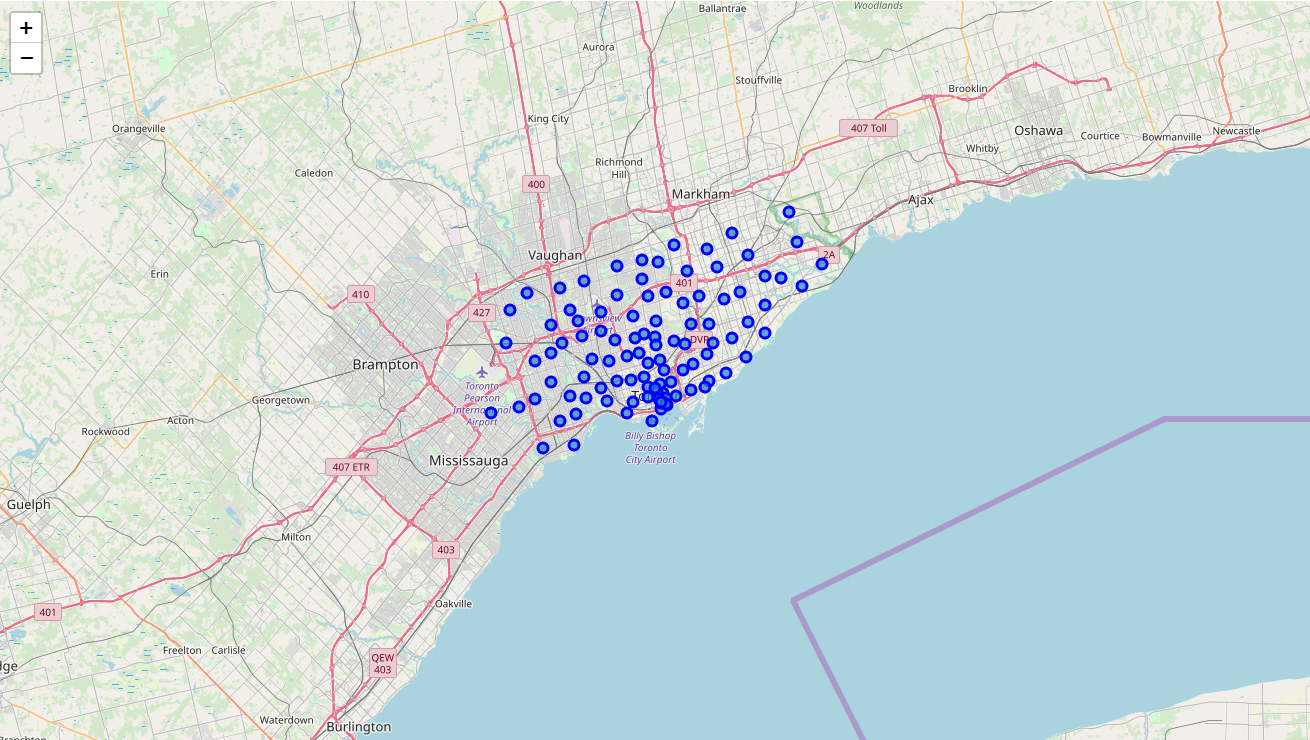

In [13]:
import IPython
IPython.display.Image("map_toronto.jpg")